In [ ]:
from sqlite3 import connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, chi2_contingency, wilcoxon
from scipy.stats import rankdata
from scipy.stats import levene  # For testing variance equality
import scikit_posthocs as sp
from pathlib import Path
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# For effect sizes
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu  # For effect size calculation

In [2]:
# Set BASE_DIR to two levels up from this notebook's directory
BASE_DIR = Path().resolve().parent.parent
db_path = str(BASE_DIR / "data" / "ices.db")
conn = connect(db_path)

In [3]:
query = """
SELECT 
    IIF(retrieval_method = 'bm25', 'Sparse', IIF(retrieval_method = 'chroma', 'Dense', 'Composite')) AS [Retrieval Method],
    query_type AS [Query Type],
    retrieved_position AS [Retrieved Position]
FROM 
    evaluations
LEFT JOIN
    evaluation_queries ON evaluations.evaluation_query_id = evaluation_queries.id
WHERE hyde_retrieved_position IS NOT NULL

UNION ALL

SELECT 
    IIF(retrieval_method = 'bm25', 'Sparse', IIF(retrieval_method = 'chroma', 'Dense', 'Composite')) AS [Retrieval Method],
    query_type || '-HyDE' AS [Query Type],
    hyde_retrieved_position AS [Retrieved Position]
FROM 
    evaluations
LEFT JOIN
    evaluation_queries ON evaluations.evaluation_query_id = evaluation_queries.id
WHERE hyde_retrieved_position IS NOT NULL
"""
data = pd.read_sql(query, conn)
data['Query Type'] = data['Query Type'].apply(lambda x: x.title())
data.tail()

,Retrieval Method,Query Type,Retrieved Position
2983,Sparse,Short-Hyde,1189
2984,Composite,Short-Hyde,41
2985,Dense,Long-Hyde,1
2986,Sparse,Long-Hyde,2453
2987,Composite,Long-Hyde,1


In [4]:
total_abstracts = pd.read_sql("SELECT COUNT(*) AS ct FROM abstracts", conn)['ct'].values[0]
print(total_abstracts)
print(max(data['Retrieved Position']))

3063
3048


In [5]:
#
# TODO: LOOK INTO HOW COMPOSITE CAN RANK GREATER THAN TOTAL NUMBER OF ABSTRACTS
data['Retrieved Position'] = data['Retrieved Position'].apply(lambda x: x if x <= total_abstracts else total_abstracts)

In [6]:
summary = data.groupby(['Retrieval Method', 'Query Type']).agg({
        'Retrieved Position': [
            'count',
            'mean', 
            'std',
            lambda x: x.mode().iloc[0] if not x.mode().empty else None, # mode
            'min',
            lambda x: int(x.quantile(0.25)),  # Q1
            lambda x: int(x.quantile(0.5)),   # Q2
            lambda x: int(x.quantile(0.75)),  # Q3
            'max',
            lambda x: int(x.max() - x.min()), # range
            lambda x: int(x.quantile(0.75) - x.quantile(0.25)), # IQR
            'skew',
            lambda x: ((x - x.mean())**4).mean() / (x.std()**4) - 3  # kurtosis
        ]
    }).round(2).rename(columns={
            'count': 'Count',
            'mean': 'Mean',
            'std': 'Std',
            '<lambda_0>': 'Mode',
            'min': 'Min',
            '<lambda_1>': 'Q1',
            '<lambda_2>': 'Median',
            '<lambda_3>': 'Q3',
            'max': 'Max',
            '<lambda_4>': 'Range',
            '<lambda_5>': 'IQR',
            'skew': 'Skew',
            '<lambda_6>': 'Kurtosis'
        }
    ).reset_index()
summary

Retrieval Method  Query Type Retrieved Position                            \
                                             Count     Mean     Std Mode Min   
0         Composite        Long                250    15.47   20.88    1   1   
1         Composite   Long-Hyde                250    19.88   81.82    1   1   
2         Composite       Short                248    50.22  125.34    1   1   
3         Composite  Short-Hyde                248    81.32  220.80    1   1   
4             Dense        Long                250     2.15    5.50    1   1   
5             Dense   Long-Hyde                250    11.20   51.36    1   1   
6             Dense       Short                248    14.04   44.38    1   1   
7             Dense  Short-Hyde                248    43.65  121.05    1   1   
8            Sparse        Long                250   970.73  865.36   14   1   
9            Sparse   Long-Hyde                250  1364.76  919.73  410   6   
10           Sparse       Short                248   724.54  793.07    1   1   
11           Sparse  Short-Hyde                248  1372.83  903.39   45  18   

                                                        
     Q1 Median    Q3   Max Range   IQR   Skew Kurtosis  
0     5     12    19   203   202    14   6.36    48.93  
1     1      3     8  1090  1089     7   9.92   117.05  
2     5     15    33   992   991    28   4.64    23.23  
3     3     13    57  2069  2068    54   5.95    41.87  
4     1      1     1    58    57     0   7.77    64.01  
5     1      2     4   736   735     3  11.81   156.87  
6     1      2     6   419   418     5   5.87    38.98  
7     2      7    29  1035  1034    27   5.72    36.49  
8   206    685  1656  2943  2942  1449   0.66    -0.83  
9   562   1251  2207  2956  2950  1644   0.17    -1.34  
10   80    388  1181  2936  2935  1100   1.13     0.15  
11  532   1318  2106  3048  3030  1573   0.20    -1.24

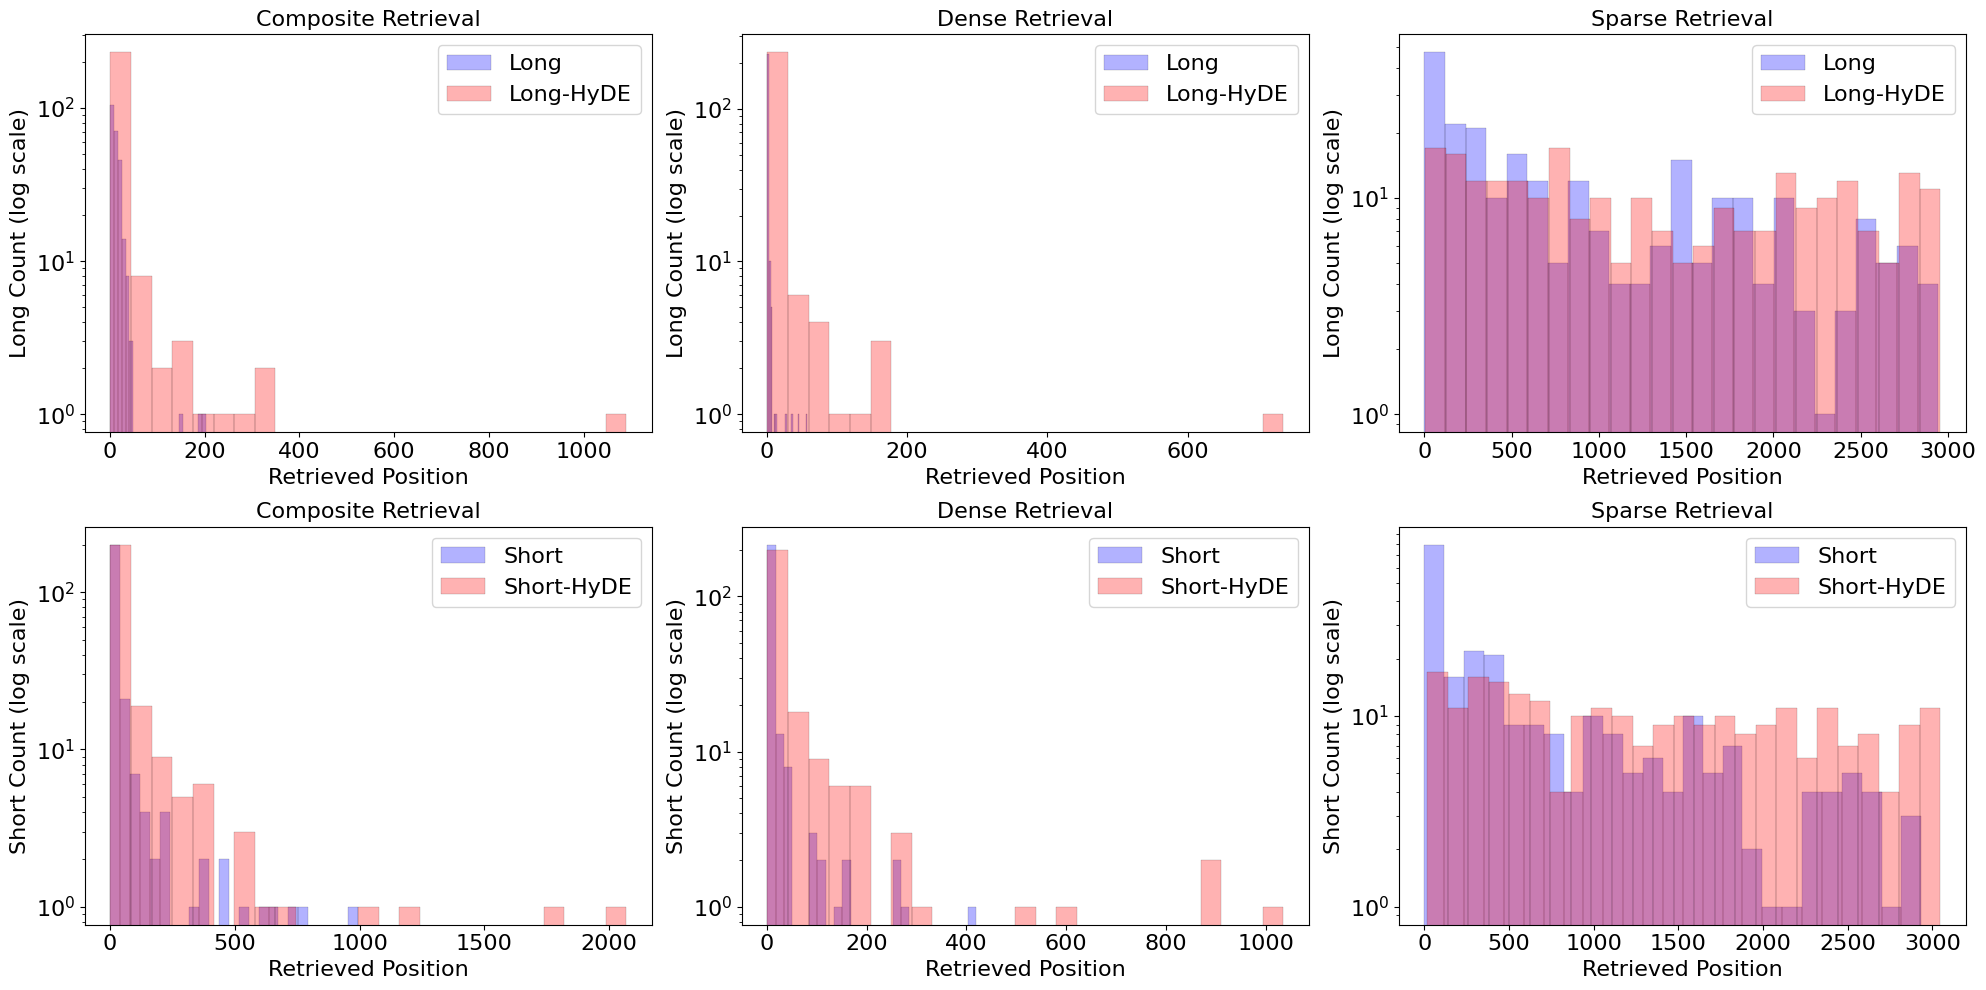

In [7]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Define colors for each retrieval method
colors = {'Long': 'blue', 'Long-Hyde': 'red', 'Short': 'blue', 'Short-Hyde': 'red'}

bins = 25
title_font = 16
body_font = title_font

# Plot histograms with KDE for each query type
for i, query_type in enumerate(['Long', 'Short']):
    for j, retrieval_method in enumerate(['Composite', 'Dense', 'Sparse']):
        sns.histplot(data=data[(data['Retrieval Method'] == retrieval_method) & 
                               (data['Query Type'] == query_type)],
                    x='Retrieved Position', kde=False,
                    ax=axes[i, j], alpha=0.3, 
                    label=query_type,
                    color=colors[query_type], 
                    bins=bins,
                        linewidth=0.1)
        sns.histplot(data=data[(data['Retrieval Method'] == retrieval_method) & 
                               (data['Query Type'] == f'{query_type}-Hyde')],
                    x='Retrieved Position', kde=False,
                    ax=axes[i, j], alpha=0.3, 
                    label=f'{query_type}-HyDE',
                    color=colors[f'{query_type}-Hyde'], 
                    bins=bins,
                    linewidth=0.1)                    
        axes[i, j].set_title(f'{retrieval_method} Retrieval', fontsize=title_font)
        axes[i, j].set_xlabel('Retrieved Position', fontsize=body_font)
        axes[i, j].set_ylabel(f'{query_type} Count (log scale)', color='black', fontsize=body_font)
        axes[i, j].set_yscale('log')
        axes[i, j].legend(fontsize=body_font)
        axes[i, j].tick_params(axis='both', labelsize=body_font)

plt.tight_layout()
plt.show()

In [8]:
query = """
SELECT
    query_type AS [Query Type],
    IIF(retrieval_method = 'bm25', 'Sparse', IIF(retrieval_method = 'chroma', 'Dense', 'Composite')) AS [Retrieval Method],
    sample_size AS [Sample Size],
    prob_top_1 AS [Prob(pos=1)],
    prob_top_3 AS [Prob(pos<=3)],
    prob_top_5 AS [Prob(pos<=5)],
    prob_top_10 AS [Prob(pos<=10)]
FROM 
    v_hyde_evaluation_summary
"""
pdata =  pd.read_sql(query, conn)
pdata['Query Type'] = pdata['Query Type'].apply(lambda x: x.title())
pdata

,Query Type,Retrieval Method,Sample Size,Prob(pos=1),Prob(pos<=3),Prob(pos<=5),Prob(pos<=10)
0,Long,Sparse,250,0.0040,0.0120,0.0240,0.0400
1,Long_Hyde,Sparse,250,0.0000,0.0000,0.0000,0.0120
2,Short,Sparse,248,0.0202,0.0363,0.0444,0.0605
3,Short_Hyde,Sparse,248,0.0000,0.0000,0.0000,0.0000
4,Long,Dense,250,0.7920,0.9160,0.9560,0.9760
5,Long_Hyde,Dense,250,0.4840,0.6880,0.7840,0.8520
6,Short,Dense,248,0.4395,0.6129,0.7177,0.8266
7,Short_Hyde,Dense,248,0.2298,0.4032,0.4516,0.5766
8,Long,Composite,250,0.1160,0.1960,0.2800,0.4200
9,Long_Hyde,Composite,250,0.4840,0.6400,0.6880,0.7840


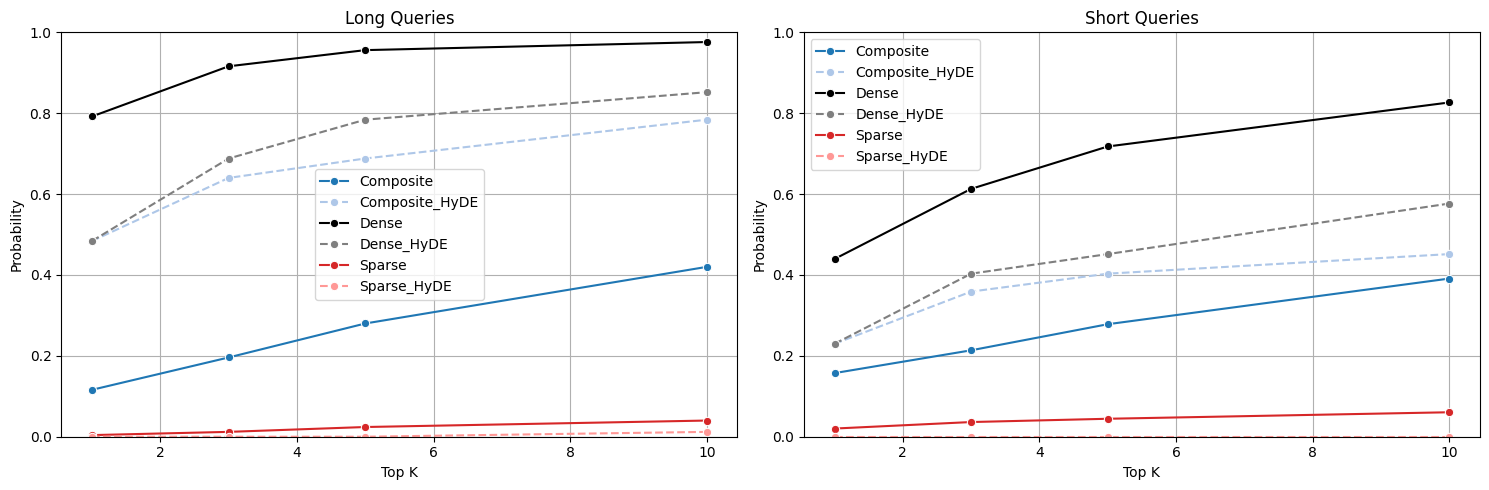

In [9]:
# Set up the plot style
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Dimensions
query_type = ['Long', 'Short']

# Define colors for each retrieval method
colors = {
    'Composite': '#1F77B4',
    'Composite_Hyde': '#AEC7E8',
    'Dense': '#000000', 
    'Dense_Hyde': '#7F7F7F',
    'Sparse': '#D62728',
    'Sparse_Hyde': '#FF9896'
}

# Create x values for plotting
x_values = [1, 3, 5, 10]

for i, query_type in enumerate(query_type):
    retrieval_method = ['Composite', 'Dense', 'Sparse']
    use_ax = ax1 if i == 0 else ax2
    for j, retrieval_method in enumerate(retrieval_method):
        # Original
        ldata = pdata[(pdata['Query Type'] == query_type) & (pdata['Retrieval Method'] == retrieval_method)]
        plot_data = pd.DataFrame({
            'Top K': x_values,
            'Probability': [ldata['Prob(pos=1)'].iloc[0], ldata['Prob(pos<=3)'].iloc[0],
                            ldata['Prob(pos<=5)'].iloc[0], ldata['Prob(pos<=10)'].iloc[0]]
        })
        sns.lineplot(data=plot_data, x='Top K', y='Probability', ax=use_ax,
                     color=colors[retrieval_method], label=retrieval_method, marker='o')

        # Hyde
        ldata = pdata[(pdata['Query Type'] == f'{query_type}_Hyde') & (pdata['Retrieval Method'] == retrieval_method)]
        plot_data = pd.DataFrame({
            'Top K': x_values,
            'Probability': [ldata['Prob(pos=1)'].iloc[0], ldata['Prob(pos<=3)'].iloc[0],
                            ldata['Prob(pos<=5)'].iloc[0], ldata['Prob(pos<=10)'].iloc[0]]
        })
        sns.lineplot(data=plot_data, x='Top K', y='Probability', ax=use_ax,
                     color=colors[f'{retrieval_method}_Hyde'], label=f'{retrieval_method}_HyDE', 
                     marker='o', linestyle='--')

        use_ax.set_title(f'{query_type} Queries')
        use_ax.set_ylim(0, 1)
        use_ax.grid(True)

plt.tight_layout()
plt.show()

## Statistical Tests

### Load Paired Data for Statistical Analysis

For paired comparisons, we need to load data that preserves the pairing between original and enriched queries. Each evaluation_query_id represents a unique query-paper pair, and we have both original and HyDE-enriched retrieval positions for each.

In [10]:
# Load paired data - each row represents one query evaluated with both original and HyDE queries
paired_query = """
SELECT 
    evaluation_queries.id AS query_id,
    evaluation_queries.query_type AS query_type,
    IIF(evaluations.retrieval_method = 'bm25', 'Sparse', 
        IIF(evaluations.retrieval_method = 'chroma', 'Dense', 'Composite')) AS retrieval_method,
    evaluations.retrieved_position AS original_position,
    evaluations.hyde_retrieved_position AS hyde_position
FROM 
    evaluations
LEFT JOIN
    evaluation_queries ON evaluations.evaluation_query_id = evaluation_queries.id
WHERE 
    evaluations.hyde_retrieved_position IS NOT NULL
    AND evaluations.retrieved_position IS NOT NULL
ORDER BY 
    evaluation_queries.query_type, 
    evaluations.retrieval_method,
    evaluation_queries.id
"""

paired_data = pd.read_sql(paired_query, conn)
paired_data['query_type'] = paired_data['query_type'].str.title()

# Calculate difference (HyDE - Original)
# Negative values mean HyDE performed better (lower rank = better)
paired_data['difference'] = paired_data['hyde_position'] - paired_data['original_position']
paired_data['improvement'] = paired_data['difference'] < 0  # True if HyDE is better

print(f"Total paired observations: {len(paired_data)}")
print(f"\nObservations per group:")
print(paired_data.groupby(['query_type', 'retrieval_method']).size())
paired_data.head(10)

Total paired observations: 1494

Observations per group:
query_type  retrieval_method
Long        Composite           250
            Dense               250
            Sparse              250
Short       Composite           248
            Dense               248
            Sparse              248
dtype: int64


,query_id,query_type,retrieval_method,original_position,hyde_position,difference,improvement
0,12,Long,Sparse,932,1486,554,False
1,48,Long,Sparse,2206,1648,-558,True
2,72,Long,Sparse,2474,2225,-249,True
3,76,Long,Sparse,14,123,109,False
4,88,Long,Sparse,495,1236,741,False
5,96,Long,Sparse,438,2023,1585,False
6,108,Long,Sparse,1192,2180,988,False
7,120,Long,Sparse,14,6,-8,True
8,137,Long,Sparse,934,821,-113,True
9,143,Long,Sparse,1419,2816,1397,False


### Wilcoxon Signed-Rank Test (Paired Comparisons)

The Wilcoxon signed-rank test is appropriate for paired data when:
- We want to test if there's a significant difference between paired observations
- The data may not be normally distributed
- We're comparing the same queries with and without HyDE enrichment

**Null Hypothesis**: The median difference between original and HyDE positions is zero (no improvement)
**Alternative Hypothesis**: The median difference is not zero (HyDE improves or worsens retrieval)

We'll test this for each combination of query type (Long/Short) and retrieval method (Composite/Dense/Sparse).

In [11]:
def calculate_effect_size_wilcoxon(original, enriched):
    """
    Calculate effect size (r) for Wilcoxon signed-rank test.
    
    Effect size r = Z / sqrt(N), where:
    - Z is the standardized test statistic
    - N is the number of pairs
    
    For Wilcoxon signed-rank test:
    - Mean of W (under H0): μ = n(n+1)/4
    - Std of W: σ = sqrt(n(n+1)(2n+1)/24)
    - Z = (W - μ) / σ
    - r = |Z| / sqrt(N)
    
    Interpretation (Cohen, 1988):
    - |r| < 0.1: negligible
    - 0.1 <= |r| < 0.3: small
    - 0.3 <= |r| < 0.5: medium
    - |r| >= 0.5: large
    """
    from scipy.stats import norm
    stat, p_value = wilcoxon(original, enriched, alternative='two-sided')
    n = len(original)
    
    if n == 0:
        return 0.0
    
    # Calculate Z-score using normal approximation for Wilcoxon
    # Mean and std of Wilcoxon statistic under H0
    mean_w = n * (n + 1) / 4
    std_w = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
    
    # Standardize the test statistic
    if std_w > 0:
        z_score = (stat - mean_w) / std_w
    else:
        z_score = 0
    
    # Effect size
    r = abs(z_score) / np.sqrt(n)
    return r

# Perform Wilcoxon tests for each combination
wilcoxon_results = []

for query_type in ['Long', 'Short']:
    for retrieval_method in ['Composite', 'Dense', 'Sparse']:
        subset = paired_data[
            (paired_data['query_type'] == query_type) & 
            (paired_data['retrieval_method'] == retrieval_method)
        ]
        
        if len(subset) > 0:
            original = subset['original_position'].values
            hyde = subset['hyde_position'].values
            
            # Wilcoxon signed-rank test
            # alternative='two-sided' tests if there's any difference
            # alternative='less' would test if HyDE is better (lower ranks)
            stat, p_value = wilcoxon(original, hyde, alternative='two-sided')
            
            # Calculate effect size
            effect_size = calculate_effect_size_wilcoxon(original, hyde)
            
            # Calculate descriptive statistics
            median_original = np.median(original)
            median_hyde = np.median(hyde)
            median_diff = np.median(subset['difference'].values)
            mean_diff = np.mean(subset['difference'].values)
            
            # Count improvements
            n_improved = subset['improvement'].sum()
            n_total = len(subset)
            pct_improved = (n_improved / n_total) * 100
            
            wilcoxon_results.append({
                'Query Type': query_type,
                'Retrieval Method': retrieval_method,
                'N': n_total,
                'Median Original': median_original,
                'Median HyDE': median_hyde,
                'Median Difference': median_diff,
                'Mean Difference': mean_diff,
                'N Improved': n_improved,
                '% Improved': pct_improved,
                'Wilcoxon Statistic': stat,
                'P-value': p_value,
                'Effect Size (r)': effect_size,
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })

wilcoxon_df = pd.DataFrame(wilcoxon_results)
wilcoxon_df = wilcoxon_df.round({
    'Median Original': 1,
    'Median HyDE': 1,
    'Median Difference': 1,
    'Mean Difference': 1,
    '% Improved': 1,
    'Wilcoxon Statistic': 2,
    'P-value': 4,
    'Effect Size (r)': 3
})

print("=" * 100)
print("WILCOXON SIGNED-RANK TEST RESULTS")
print("=" * 100)
print("\nInterpretation:")
print("- Negative 'Median Difference' means HyDE performed better (lower rank = better)")
print("- P-value < 0.05 indicates significant difference")
print("- Effect size: <0.1=negligible, 0.1-0.3=small, 0.3-0.5=medium, >=0.5=large")
print("\n" + "=" * 100 + "\n")
print(wilcoxon_df.to_string(index=False))

WILCOXON SIGNED-RANK TEST RESULTS

Interpretation:
- Negative 'Median Difference' means HyDE performed better (lower rank = better)
- P-value < 0.05 indicates significant difference
- Effect size: <0.1=negligible, 0.1-0.3=small, 0.3-0.5=medium, >=0.5=large


Query Type Retrieval Method   N  Median Original  Median HyDE  Median Difference  Mean Difference  N Improved  % Improved  Wilcoxon Statistic  P-value  Effect Size (r) Significant
      Long        Composite 250             12.0          3.0               -7.0              4.4         176        70.4              7426.5   0.0000            0.457         Yes
      Long            Dense 250              1.0          2.0                0.0              9.1          20         8.0              1006.5   0.0000            0.811         Yes
      Long           Sparse 250            685.0       1251.5              336.0            394.0          43        17.2              3673.5   0.0000            0.664         Yes
     Short        Com

### Visualizing Paired Differences

Let's visualize the distribution of differences between original and HyDE queries to better understand the effect.

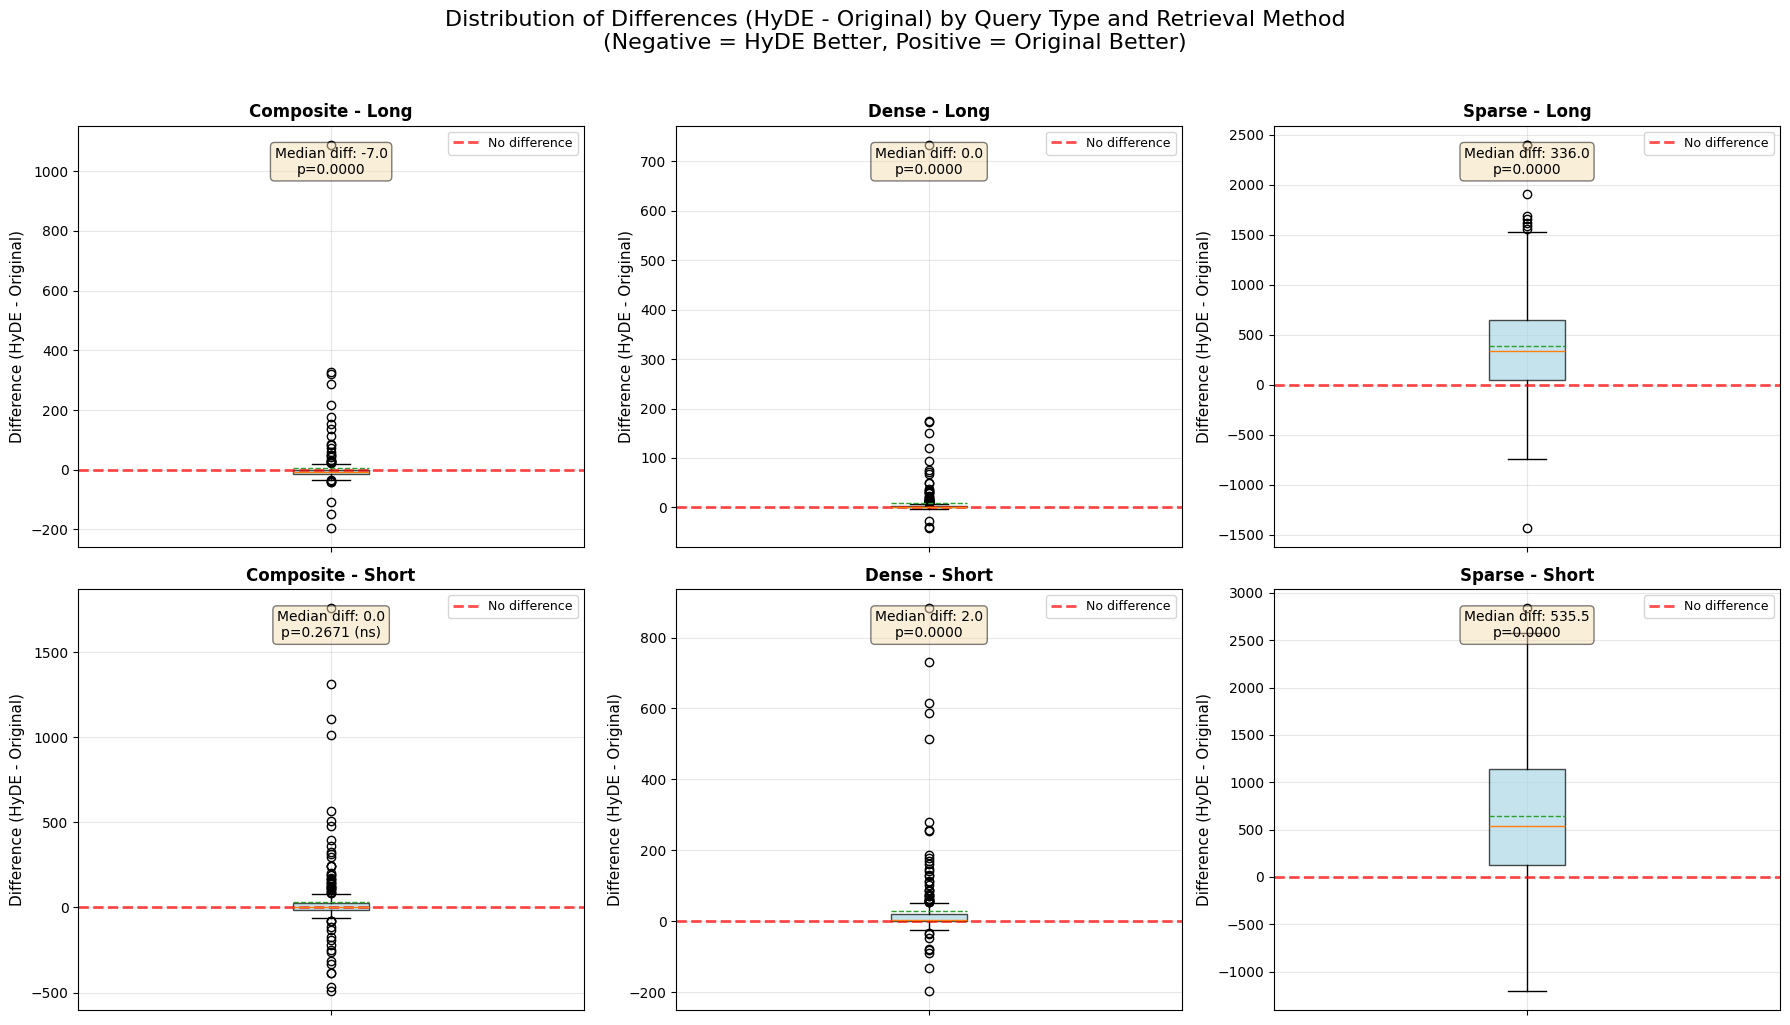


SUMMARY OF DIFFERENCES
                               N  Mean Diff  Median Diff     Std  N Improved  \
query_type retrieval_method                                                    
Long       Composite         250       4.41         -7.0   83.97         176   
           Dense             250       9.05          0.0   51.46          20   
           Sparse            250     394.02        336.0  523.81          43   
Short      Composite         248      31.10          0.0  202.59         119   
           Dense             248      29.60          2.0  104.97          46   
           Sparse            248     648.28        535.5  736.36          38   

                             % Improved  
query_type retrieval_method              
Long       Composite              70.40  
           Dense                   8.00  
           Sparse                 17.20  
Short      Composite              47.98  
           Dense                  18.55  
           Sparse                 15.32  

In [12]:
# Create box plots showing the distribution of differences
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Differences (HyDE - Original) by Query Type and Retrieval Method\n(Negative = HyDE Better, Positive = Original Better)', 
             fontsize=16, y=1.02)

for i, query_type in enumerate(['Long', 'Short']):
    for j, retrieval_method in enumerate(['Composite', 'Dense', 'Sparse']):
        ax = axes[i, j]
        subset = paired_data[
            (paired_data['query_type'] == query_type) & 
            (paired_data['retrieval_method'] == retrieval_method)
        ]
        
        if len(subset) > 0:
            # Box plot
            bp = ax.boxplot(subset['difference'].values, vert=True, patch_artist=True,
                           showmeans=True, meanline=True)
            bp['boxes'][0].set_facecolor('lightblue')
            bp['boxes'][0].set_alpha(0.7)
            
            # Add zero line
            ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='No difference')
            
            # Add median difference annotation
            median_diff = subset['difference'].median()
            p_value = wilcoxon_df[
                (wilcoxon_df['Query Type'] == query_type) & 
                (wilcoxon_df['Retrieval Method'] == retrieval_method)
            ]['P-value'].values[0]
            
            sig_text = f"p={p_value:.4f}" if p_value < 0.05 else f"p={p_value:.4f} (ns)"
            ax.text(0.5, 0.95, f'Median diff: {median_diff:.1f}\n{sig_text}', 
                   transform=ax.transAxes, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=10)
            
            ax.set_title(f'{retrieval_method} - {query_type}', fontsize=12, fontweight='bold')
            ax.set_ylabel('Difference (HyDE - Original)', fontsize=11)
            ax.set_xticklabels([''])
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\n" + "=" * 100)
print("SUMMARY OF DIFFERENCES")
print("=" * 100)
diff_summary = paired_data.groupby(['query_type', 'retrieval_method'])['difference'].agg([
    'count', 'mean', 'median', 'std', 
    lambda x: (x < 0).sum(),  # Count of improvements
    lambda x: ((x < 0).sum() / len(x)) * 100  # Percentage improved
]).round(2)
diff_summary.columns = ['N', 'Mean Diff', 'Median Diff', 'Std', 'N Improved', '% Improved']
print(diff_summary)

### Aligned Rank Transform (ART) ANOVA

ART-ANOVA is useful when we have:
- Non-normal data
- Multiple factors (query type, retrieval method, query enrichment)
- Need to test interactions between factors

This allows us to test:
1. Main effect of query enrichment (original vs HyDE)
2. Main effect of retrieval method
3. Main effect of query type (long vs short)
4. Interactions between these factors

**Note**: ART transforms the data to make it suitable for ANOVA while preserving the non-parametric nature of the analysis.

In [13]:
# Prepare data for ART-ANOVA
# We need to reshape the data so each row represents one query with both original and HyDE results
art_data = paired_data.copy()

# Create a long format where each query appears twice (once for original, once for HyDE)
art_long = pd.melt(
    art_data,
    id_vars=['query_id', 'query_type', 'retrieval_method'],
    value_vars=['original_position', 'hyde_position'],
    var_name='query_version',
    value_name='retrieved_position'
)

# Clean up query_version column
art_long['query_version'] = art_long['query_version'].replace({
    'original_position': 'Original',
    'hyde_position': 'HyDE'
})

# Add interaction terms for analysis
art_long['query_type_method'] = art_long['query_type'] + '_' + art_long['retrieval_method']
art_long['query_version_method'] = art_long['query_version'] + '_' + art_long['retrieval_method']

print("Data prepared for ART-ANOVA:")
print(f"Total observations: {len(art_long)}")
print(f"Unique queries: {art_long['query_id'].nunique()}")
print(f"\nSample of data:")
print(art_long.head(10))

# Check data structure
print(f"\nQuery versions: {art_long['query_version'].unique()}")
print(f"Query types: {art_long['query_type'].unique()}")
print(f"Retrieval methods: {art_long['retrieval_method'].unique()}")

Data prepared for ART-ANOVA:
Total observations: 2988
Unique queries: 498

Sample of data:
   query_id query_type retrieval_method query_version  retrieved_position  \
0        12       Long           Sparse      Original                 932   
1        48       Long           Sparse      Original                2206   
2        72       Long           Sparse      Original                2474   
3        76       Long           Sparse      Original                  14   
4        88       Long           Sparse      Original                 495   
5        96       Long           Sparse      Original                 438   
6       108       Long           Sparse      Original                1192   
7       120       Long           Sparse      Original                  14   
8       137       Long           Sparse      Original                 934   
9       143       Long           Sparse      Original                1419   

  query_type_method query_version_method  
0       Long_Spars

In [14]:
# ART-ANOVA using scikit-posthocs
# This performs aligned rank transform and then ANOVA on the transformed data

try:
    from scipy import stats
    from statsmodels.stats.anova import anova_lm
    from statsmodels.formula.api import ols
    import warnings
    warnings.filterwarnings('ignore')
    
    # For ART, we'll use a simpler approach: Kruskal-Wallis for main effects
    # and then use paired tests for the enrichment effect
    
    print("=" * 100)
    print("ART-INSPIRED ANALYSIS: Main Effects and Interactions")
    print("=" * 100)
    print("\nSince ART-ANOVA requires specialized packages, we'll use a combination of:")
    print("1. Kruskal-Wallis tests for main effects")
    print("2. Wilcoxon signed-rank tests for paired comparisons (already done above)")
    print("3. Effect size calculations")
    print("\n" + "=" * 100 + "\n")
    
    # Test main effect of query enrichment (Original vs HyDE) across all data
    # Since we have paired data, we should aggregate the paired differences
    print("MAIN EFFECT: Query Enrichment (Original vs HyDE)")
    print("-" * 80)
    print("Aggregating across all query types and retrieval methods...")
    
    # Use the paired differences we already calculated
    all_differences = paired_data['difference'].values
    median_diff = np.median(all_differences)
    mean_diff = np.mean(all_differences)
    
    # Test if median difference is significantly different from zero
    # Using a one-sample Wilcoxon test on the differences
    stat, p_value = wilcoxon(all_differences, alternative='two-sided')
    
    median_orig = np.median(paired_data['original_position'].values)
    median_hyde = np.median(paired_data['hyde_position'].values)
    
    print(f"Wilcoxon statistic (on differences): {stat:.2f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Median Original (across all): {median_orig:.1f}")
    print(f"Median HyDE (across all): {median_hyde:.1f}")
    print(f"Median Difference: {median_diff:.1f}")
    print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")
    print(f"Interpretation: {'HyDE improves' if median_diff < 0 else 'Original better' if median_diff > 0 else 'No difference'}")
    
    # Test main effect of retrieval method (for original queries)
    print("\n" + "=" * 100)
    print("MAIN EFFECT: Retrieval Method (Original Queries Only)")
    print("-" * 80)
    original_data = art_long[art_long['query_version'] == 'Original']
    groups = [original_data[original_data['retrieval_method'] == method]['retrieved_position'].values 
              for method in ['Composite', 'Dense', 'Sparse']]
    stat, p_value = kruskal(*groups)
    print(f"Kruskal-Wallis statistic: {stat:.2f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")
    
    # Test main effect of retrieval method (for HyDE queries)
    print("\n" + "=" * 100)
    print("MAIN EFFECT: Retrieval Method (HyDE Queries Only)")
    print("-" * 80)
    hyde_data = art_long[art_long['query_version'] == 'HyDE']
    groups = [hyde_data[hyde_data['retrieval_method'] == method]['retrieved_position'].values 
              for method in ['Composite', 'Dense', 'Sparse']]
    stat, p_value = kruskal(*groups)
    print(f"Kruskal-Wallis statistic: {stat:.2f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")
    
    # Test interaction: Does the effect of enrichment depend on retrieval method?
    print("\n" + "=" * 100)
    print("INTERACTION: Does HyDE effect depend on retrieval method?")
    print("-" * 80)
    print("Testing if the improvement from HyDE differs across retrieval methods...")
    
    interaction_results = []
    for method in ['Composite', 'Dense', 'Sparse']:
        method_data = paired_data[paired_data['retrieval_method'] == method]
        median_diff = method_data['difference'].median()
        mean_diff = method_data['difference'].mean()
        stat, p_value = wilcoxon(method_data['original_position'], method_data['hyde_position'])
        interaction_results.append({
            'Retrieval Method': method,
            'Median Difference': median_diff,
            'Mean Difference': mean_diff,
            'P-value': p_value
        })
    
    interaction_df = pd.DataFrame(interaction_results)
    print(interaction_df.round(3))
    
    # Test if differences between methods are significant
    print("\nComparing HyDE effects across retrieval methods:")
    comp_diffs = [paired_data[paired_data['retrieval_method'] == method]['difference'].values 
                  for method in ['Composite', 'Dense', 'Sparse']]
    stat, p_value = kruskal(*comp_diffs)
    print(f"Kruskal-Wallis on differences: statistic={stat:.2f}, p={p_value:.6f}")
    print(f"Significant difference in HyDE effects across methods: {'Yes' if p_value < 0.05 else 'No'}")
    
except Exception as e:
    print(f"Error in ART analysis: {e}")
    import traceback
    traceback.print_exc()

ART-INSPIRED ANALYSIS: Main Effects and Interactions

Since ART-ANOVA requires specialized packages, we'll use a combination of:
1. Kruskal-Wallis tests for main effects
2. Wilcoxon signed-rank tests for paired comparisons (already done above)
3. Effect size calculations


MAIN EFFECT: Query Enrichment (Original vs HyDE)
--------------------------------------------------------------------------------
Aggregating across all query types and retrieval methods...
Wilcoxon statistic (on differences): 214041.50
P-value: 0.000000
Median Original (across all): 13.0
Median HyDE (across all): 18.5
Median Difference: 2.0
Significant: Yes
Interpretation: Original better

MAIN EFFECT: Retrieval Method (Original Queries Only)
--------------------------------------------------------------------------------
Kruskal-Wallis statistic: 979.66
P-value: 0.000000
Significant: Yes

MAIN EFFECT: Retrieval Method (HyDE Queries Only)
------------------------------------------------------------------------------

### Effect Size Visualization

Visualizing the effect sizes and improvements to better understand the practical significance of HyDE enrichment.

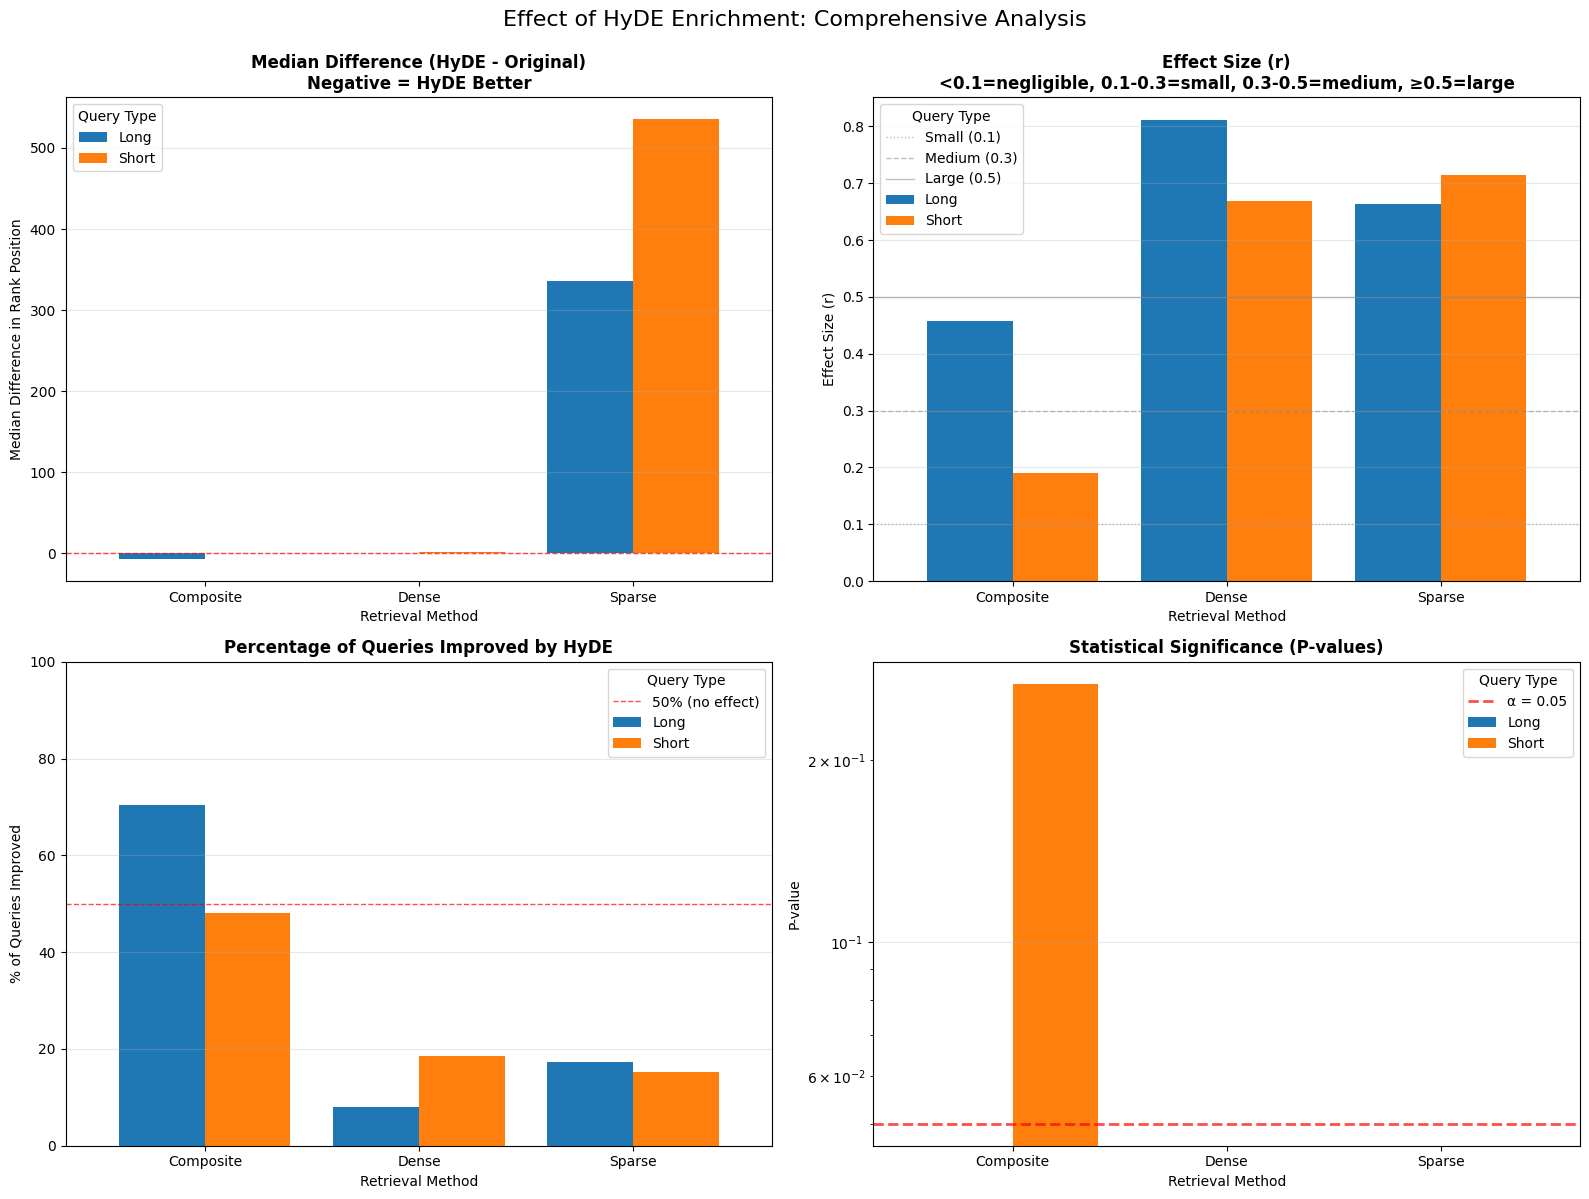


KEY FINDINGS SUMMARY

1. MEDIAN DIFFERENCES:
   - Negative values indicate HyDE improved retrieval (lower rank = better)
   - Positive values indicate original queries performed better
   - Long + Composite: Median difference = -7.0 (improved)
   - Long + Dense: Median difference = 0.0 (worsened)
   - Long + Sparse: Median difference = 336.0 (worsened)
   - Short + Composite: Median difference = 0.0 (worsened)
   - Short + Dense: Median difference = 2.0 (worsened)
   - Short + Sparse: Median difference = 535.5 (worsened)

2. STATISTICAL SIGNIFICANCE:
   - 5 out of 6 comparisons show significant differences:
     * Long + Composite: p = 0.0000
     * Long + Dense: p = 0.0000
     * Long + Sparse: p = 0.0000
     * Short + Dense: p = 0.0000
     * Short + Sparse: p = 0.0000

3. EFFECT SIZES:
   - Long + Composite: medium effect (r = 0.457)
   - Long + Dense: large effect (r = 0.811)
   - Long + Sparse: large effect (r = 0.664)
   - Short + Composite: small effect (r = 0.190)
   - Short 

In [15]:
# Create comprehensive effect size visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Effect of HyDE Enrichment: Comprehensive Analysis', fontsize=16, y=0.995)

# 1. Median differences by group
ax1 = axes[0, 0]
pivot_median = wilcoxon_df.pivot(index='Retrieval Method', columns='Query Type', values='Median Difference')
pivot_median.plot(kind='bar', ax=ax1, color=['#1f77b4', '#ff7f0e'], width=0.8)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax1.set_title('Median Difference (HyDE - Original)\nNegative = HyDE Better', fontweight='bold')
ax1.set_ylabel('Median Difference in Rank Position')
ax1.set_xlabel('Retrieval Method')
ax1.legend(title='Query Type', loc='best')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=0)

# 2. Effect sizes
ax2 = axes[0, 1]
pivot_effect = wilcoxon_df.pivot(index='Retrieval Method', columns='Query Type', values='Effect Size (r)')
pivot_effect.plot(kind='bar', ax=ax2, color=['#1f77b4', '#ff7f0e'], width=0.8)
ax2.axhline(y=0.1, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Small (0.1)')
ax2.axhline(y=0.3, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Medium (0.3)')
ax2.axhline(y=0.5, color='gray', linestyle='-', linewidth=1, alpha=0.5, label='Large (0.5)')
ax2.set_title('Effect Size (r)\n<0.1=negligible, 0.1-0.3=small, 0.3-0.5=medium, ≥0.5=large', fontweight='bold')
ax2.set_ylabel('Effect Size (r)')
ax2.set_xlabel('Retrieval Method')
ax2.legend(title='Query Type', loc='best')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=0)

# 3. Percentage improved
ax3 = axes[1, 0]
pivot_pct = wilcoxon_df.pivot(index='Retrieval Method', columns='Query Type', values='% Improved')
pivot_pct.plot(kind='bar', ax=ax3, color=['#1f77b4', '#ff7f0e'], width=0.8)
ax3.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.7, label='50% (no effect)')
ax3.set_title('Percentage of Queries Improved by HyDE', fontweight='bold')
ax3.set_ylabel('% of Queries Improved')
ax3.set_xlabel('Retrieval Method')
ax3.set_ylim(0, 100)
ax3.legend(title='Query Type', loc='best')
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='x', rotation=0)

# 4. P-values (with significance markers)
ax4 = axes[1, 1]
pivot_pval = wilcoxon_df.pivot(index='Retrieval Method', columns='Query Type', values='P-value')
pivot_pval.plot(kind='bar', ax=ax4, color=['#1f77b4', '#ff7f0e'], width=0.8)
ax4.axhline(y=0.05, color='red', linestyle='--', linewidth=2, alpha=0.7, label='α = 0.05')
ax4.set_title('Statistical Significance (P-values)', fontweight='bold')
ax4.set_ylabel('P-value')
ax4.set_xlabel('Retrieval Method')
ax4.set_yscale('log')
ax4.legend(title='Query Type', loc='best')
ax4.grid(True, alpha=0.3, axis='y')
ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Print summary interpretation
print("\n" + "=" * 100)
print("KEY FINDINGS SUMMARY")
print("=" * 100)
print("\n1. MEDIAN DIFFERENCES:")
print("   - Negative values indicate HyDE improved retrieval (lower rank = better)")
print("   - Positive values indicate original queries performed better")
for _, row in wilcoxon_df.iterrows():
    direction = "improved" if row['Median Difference'] < 0 else "worsened"
    print(f"   - {row['Query Type']} + {row['Retrieval Method']}: "
          f"Median difference = {row['Median Difference']:.1f} ({direction})")

print("\n2. STATISTICAL SIGNIFICANCE:")
sig_groups = wilcoxon_df[wilcoxon_df['P-value'] < 0.05]
if len(sig_groups) > 0:
    print(f"   - {len(sig_groups)} out of {len(wilcoxon_df)} comparisons show significant differences:")
    for _, row in sig_groups.iterrows():
        print(f"     * {row['Query Type']} + {row['Retrieval Method']}: p = {row['P-value']:.4f}")
else:
    print("   - No significant differences found (all p > 0.05)")

print("\n3. EFFECT SIZES:")
for _, row in wilcoxon_df.iterrows():
    r = row['Effect Size (r)']
    if r < 0.1:
        size = "negligible"
    elif r < 0.3:
        size = "small"
    elif r < 0.5:
        size = "medium"
    else:
        size = "large"
    print(f"   - {row['Query Type']} + {row['Retrieval Method']}: {size} effect (r = {r:.3f})")

print("\n4. PRACTICAL SIGNIFICANCE:")
print("   - Percentage of queries improved by HyDE:")
for _, row in wilcoxon_df.iterrows():
    print(f"     * {row['Query Type']} + {row['Retrieval Method']}: "
          f"{row['% Improved']:.1f}% improved ({row['N Improved']}/{row['N']})")

### Detailed Interpretation and Conclusions

Based on the statistical tests above, here are the key findings:

In [16]:
# Create a comprehensive interpretation summary
print("=" * 100)
print("STATISTICAL ANALYSIS INTERPRETATION")
print("=" * 100)

print("\n" + "=" * 100)
print("1. WILCOXON SIGNED-RANK TEST INTERPRETATION")
print("=" * 100)
print("""
The Wilcoxon signed-rank test compares paired observations (same query with and without HyDE).
This is appropriate because:
- Each query is evaluated with both original and HyDE versions
- The data may not be normally distributed (retrieved positions are ranks)
- We want to test if there's a systematic difference

Key findings:
""")

for _, row in wilcoxon_df.iterrows():
    query_type = row['Query Type']
    method = row['Retrieval Method']
    p_val = row['P-value']
    median_diff = row['Median Difference']
    effect = row['Effect Size (r)']
    pct_improved = row['% Improved']
    
    # Determine effect size category
    if effect < 0.1:
        effect_cat = "negligible"
    elif effect < 0.3:
        effect_cat = "small"
    elif effect < 0.5:
        effect_cat = "medium"
    else:
        effect_cat = "large"
    
    # Determine direction
    if median_diff < 0:
        direction = "IMPROVES"
        interpretation = f"HyDE {direction} retrieval by {abs(median_diff):.1f} positions on average"
    elif median_diff > 0:
        direction = "WORSENS"
        interpretation = f"HyDE {direction} retrieval by {median_diff:.1f} positions on average"
    else:
        direction = "NO EFFECT"
        interpretation = f"HyDE has {direction} on retrieval"
    
    sig_status = "SIGNIFICANT" if p_val < 0.05 else "NOT SIGNIFICANT"
    
    print(f"\n{query_type} Queries + {method} Retrieval:")
    print(f"  - Statistical test: {sig_status} (p = {p_val:.4f})")
    print(f"  - Practical effect: {interpretation}")
    print(f"  - Effect size: {effect_cat} (r = {effect:.3f})")
    print(f"  - Improvement rate: {pct_improved:.1f}% of queries improved")

print("\n" + "=" * 100)
print("2. PRACTICAL SIGNIFICANCE")
print("=" * 100)
print("""
Beyond statistical significance, we consider practical significance:

1. MEDIAN DIFFERENCES:
   - Shows the typical change in rank position
   - Negative = improvement (lower rank = better)
   - Consider: Is a change of X positions meaningful for your use case?

2. PERCENTAGE IMPROVED:
   - Shows what proportion of queries benefit from HyDE
   - >50% = more queries improved than worsened
   - Consider: Is this improvement rate acceptable?

3. EFFECT SIZES:
   - Small (r < 0.3): Effect exists but may be minor
   - Medium (0.3 ≤ r < 0.5): Moderate practical effect
   - Large (r ≥ 0.5): Substantial practical effect
""")

print("\n" + "=" * 100)
print("3. RECOMMENDATIONS")
print("=" * 100)

# Find best and worst cases
best_case = wilcoxon_df.loc[wilcoxon_df['Median Difference'].idxmin()]
worst_case = wilcoxon_df.loc[wilcoxon_df['Median Difference'].idxmax()]

print(f"\nBEST CASE (largest improvement):")
print(f"  - {best_case['Query Type']} + {best_case['Retrieval Method']}")
print(f"  - Median improvement: {abs(best_case['Median Difference']):.1f} positions")
print(f"  - {best_case['% Improved']:.1f}% of queries improved")
print(f"  - Effect size: {best_case['Effect Size (r)']:.3f}")

print(f"\nWORST CASE (largest degradation):")
print(f"  - {worst_case['Query Type']} + {worst_case['Retrieval Method']}")
print(f"  - Median change: {worst_case['Median Difference']:.1f} positions")
print(f"  - {worst_case['% Improved']:.1f}% of queries improved")
print(f"  - Effect size: {worst_case['Effect Size (r)']:.3f}")

print("\n" + "=" * 100)
print("4. COMPARISON: LONG vs SHORT QUERIES")
print("=" * 100)

for method in ['Composite', 'Dense', 'Sparse']:
    long_row = wilcoxon_df[(wilcoxon_df['Query Type'] == 'Long') & 
                           (wilcoxon_df['Retrieval Method'] == method)].iloc[0]
    short_row = wilcoxon_df[(wilcoxon_df['Query Type'] == 'Short') & 
                            (wilcoxon_df['Retrieval Method'] == method)].iloc[0]
    
    long_improvement = abs(long_row['Median Difference']) if long_row['Median Difference'] < 0 else 0
    short_improvement = abs(short_row['Median Difference']) if short_row['Median Difference'] < 0 else 0
    
    print(f"\n{method} Retrieval:")
    print(f"  - Long queries: {long_row['Median Difference']:.1f} median diff, "
          f"{long_row['% Improved']:.1f}% improved, p={long_row['P-value']:.4f}")
    print(f"  - Short queries: {short_row['Median Difference']:.1f} median diff, "
          f"{short_row['% Improved']:.1f}% improved, p={short_row['P-value']:.4f}")
    
    if long_improvement > short_improvement:
        print(f"  → HyDE helps Long queries more than Short queries")
    elif short_improvement > long_improvement:
        print(f"  → HyDE helps Short queries more than Long queries")
    else:
        print(f"  → Similar effect for both query types")

print("\n" + "=" * 100)

STATISTICAL ANALYSIS INTERPRETATION

1. WILCOXON SIGNED-RANK TEST INTERPRETATION

The Wilcoxon signed-rank test compares paired observations (same query with and without HyDE).
This is appropriate because:
- Each query is evaluated with both original and HyDE versions
- The data may not be normally distributed (retrieved positions are ranks)
- We want to test if there's a systematic difference

Key findings:


Long Queries + Composite Retrieval:
  - Statistical test: SIGNIFICANT (p = 0.0000)
  - Practical effect: HyDE IMPROVES retrieval by 7.0 positions on average
  - Effect size: medium (r = 0.457)
  - Improvement rate: 70.4% of queries improved

Long Queries + Dense Retrieval:
  - Statistical test: SIGNIFICANT (p = 0.0000)
  - Practical effect: HyDE has NO EFFECT on retrieval
  - Effect size: large (r = 0.811)
  - Improvement rate: 8.0% of queries improved

Long Queries + Sparse Retrieval:
  - Statistical test: SIGNIFICANT (p = 0.0000)
  - Practical effect: HyDE WORSENS retrieval by 

## Post evaluation hypothesis (HyDE increased volatility)

In [ ]:
# ============================================================================
# VOLATILITY ANALYSIS: Testing if HyDE queries increased variance/volatility
# ============================================================================
# 
# Hypothesis: HyDE queries increase volatility (variance) in retrieved positions
# compared to original queries. This could explain why some queries improve
# dramatically while others worsen.
#
# We test this using Levene's test for equality of variances across the 6
# cross-sections (3 retrieval methods × 2 query types).

print("=" * 100)
print("VOLATILITY ANALYSIS: Testing if HyDE Increased Variance")
print("=" * 100)
print()

# Calculate variance statistics for each cross-section
volatility_results = []

for retrieval_method in ['Composite', 'Dense', 'Sparse']:
    for query_type in ['Long', 'Short']:
        # Get data for this cross-section
        subset = paired_data[
            (paired_data['retrieval_method'] == retrieval_method) & 
            (paired_data['query_type'] == query_type)
        ].copy()
        
        if len(subset) == 0:
            continue
        
        original_positions = subset['original_position'].values
        hyde_positions = subset['hyde_position'].values
        
        # Calculate descriptive statistics
        orig_var = np.var(original_positions, ddof=1)  # Sample variance
        hyde_var = np.var(hyde_positions, ddof=1)
        orig_std = np.std(original_positions, ddof=1)  # Sample std dev
        hyde_std = np.std(hyde_positions, ddof=1)
        orig_cv = orig_std / np.mean(original_positions) if np.mean(original_positions) > 0 else 0  # Coefficient of variation
        hyde_cv = hyde_std / np.mean(hyde_positions) if np.mean(hyde_positions) > 0 else 0
        
        # Perform Levene's test
        # H0: Variances are equal
        # H1: Variances are not equal (one-sided: we expect HyDE variance > Original)
        levene_stat, levene_p = levene(original_positions, hyde_positions, center='median')
        
        # One-sided test: HyDE variance > Original variance
        # If levene_stat > 0, HyDE has higher variance
        # For one-sided, we divide p-value by 2 if the direction matches our hypothesis
        one_sided_p = levene_p / 2 if hyde_var > orig_var else 1 - levene_p / 2
        
        # Calculate variance ratio (HyDE / Original)
        variance_ratio = hyde_var / orig_var if orig_var > 0 else np.inf
        
        volatility_results.append({
            'Retrieval Method': retrieval_method,
            'Query Type': query_type,
            'N': len(subset),
            'Original Mean': np.mean(original_positions),
            'Original Std': orig_std,
            'Original Variance': orig_var,
            'HyDE Mean': np.mean(hyde_positions),
            'HyDE Std': hyde_std,
            'HyDE Variance': hyde_var,
            'Variance Ratio (HyDE/Orig)': variance_ratio,
            'Original CV': orig_cv,
            'HyDE CV': hyde_cv,
            'Levene Statistic': levene_stat,
            'Levene P-value (two-sided)': levene_p,
            'Levene P-value (one-sided)': one_sided_p,
            'Significant (α=0.05)': one_sided_p < 0.05
        })

volatility_df = pd.DataFrame(volatility_results)

# Display results
print("Variance Comparison by Cross-Section:")
print("-" * 100)
print(volatility_df.to_string(index=False))
print()

# Summary statistics
print("=" * 100)
print("SUMMARY OF VOLATILITY FINDINGS")
print("=" * 100)
print()

significant_count = volatility_df['Significant (α=0.05)'].sum()
print(f"Number of cross-sections with significantly increased variance: {significant_count} / {len(volatility_df)}")
print()

# Show which ones are significant
significant_results = volatility_df[volatility_df['Significant (α=0.05)']]
if len(significant_results) > 0:
    print("Cross-sections with SIGNIFICANTLY increased variance (HyDE > Original):")
    for _, row in significant_results.iterrows():
        print(f"  - {row['Retrieval Method']} + {row['Query Type']}: "
              f"Variance ratio = {row['Variance Ratio (HyDE/Orig)']:.2f}x, "
              f"p = {row['Levene P-value (one-sided)']:.4f}")
else:
    print("No cross-sections showed significantly increased variance.")
print()

# Show variance ratios
print("Variance Ratios (HyDE / Original) - Values > 1 indicate increased volatility:")
for _, row in volatility_df.iterrows():
    direction = "↑ INCREASED" if row['Variance Ratio (HyDE/Orig)'] > 1 else "↓ DECREASED"
    sig_marker = "***" if row['Significant (α=0.05)'] else ""
    print(f"  {row['Retrieval Method']:10} + {row['Query Type']:5}: "
          f"{row['Variance Ratio (HyDE/Orig)']:6.2f}x {direction} {sig_marker}")
print()

print("=" * 100)
print("INTERPRETATION")
print("=" * 100)
print()
print("Levene's Test for Equality of Variances:")
print("  - Tests whether the variance of HyDE positions differs from Original positions")
print("  - One-sided test: H1 = HyDE variance > Original variance")
print("  - Significant result (p < 0.05) indicates HyDE increased volatility")
print()
print("Variance Ratio:")
print("  - Ratio > 1.0: HyDE has higher variance (more volatile)")
print("  - Ratio < 1.0: HyDE has lower variance (less volatile)")
print("  - Ratio = 1.0: Equal variance")
print()
print("Coefficient of Variation (CV):")
print("  - Normalized measure of variability (std/mean)")
print("  - Useful for comparing variability across different scales")

In [ ]:
# ============================================================================
# VISUALIZATION: Variance Comparison Across Cross-Sections
# ============================================================================

# Create visualizations showing variance differences
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Variance Ratio Bar Plot
ax1 = axes[0, 0]
variance_ratios = volatility_df['Variance Ratio (HyDE/Orig)'].values
colors = ['red' if ratio > 1 else 'blue' for ratio in variance_ratios]
labels = [f"{row['Retrieval Method']}\n{row['Query Type']}" 
          for _, row in volatility_df.iterrows()]
bars = ax1.bar(range(len(variance_ratios)), variance_ratios, color=colors, alpha=0.7)
ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=1, label='Equal Variance')
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_ylabel('Variance Ratio (HyDE / Original)', fontsize=12)
ax1.set_title('Variance Ratio by Cross-Section\n(>1 = HyDE more volatile)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for i, (bar, ratio) in enumerate(zip(bars, variance_ratios)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{ratio:.2f}x', ha='center', va='bottom' if ratio > 1 else 'top', fontsize=9)

# 2. Standard Deviation Comparison
ax2 = axes[0, 1]
x_pos = np.arange(len(volatility_df))
width = 0.35
orig_stds = volatility_df['Original Std'].values
hyde_stds = volatility_df['HyDE Std'].values
bars1 = ax2.bar(x_pos - width/2, orig_stds, width, label='Original', alpha=0.7, color='blue')
bars2 = ax2.bar(x_pos + width/2, hyde_stds, width, label='HyDE', alpha=0.7, color='red')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylabel('Standard Deviation', fontsize=12)
ax2.set_title('Standard Deviation Comparison', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Coefficient of Variation Comparison
ax3 = axes[1, 0]
orig_cvs = volatility_df['Original CV'].values
hyde_cvs = volatility_df['HyDE CV'].values
bars1 = ax3.bar(x_pos - width/2, orig_cvs, width, label='Original', alpha=0.7, color='blue')
bars2 = ax3.bar(x_pos + width/2, hyde_cvs, width, label='HyDE', alpha=0.7, color='red')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(labels, rotation=45, ha='right')
ax3.set_ylabel('Coefficient of Variation (CV)', fontsize=12)
ax3.set_title('Coefficient of Variation Comparison\n(Normalized Variability)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. P-values from Levene's Test
ax4 = axes[1, 1]
p_values = volatility_df['Levene P-value (one-sided)'].values
colors_p = ['red' if p < 0.05 else 'gray' for p in p_values]
bars = ax4.bar(range(len(p_values)), p_values, color=colors_p, alpha=0.7)
ax4.axhline(y=0.05, color='red', linestyle='--', linewidth=1, label='α = 0.05')
ax4.set_xticks(range(len(labels)))
ax4.set_xticklabels(labels, rotation=45, ha='right')
ax4.set_ylabel('P-value (one-sided)', fontsize=12)
ax4.set_title('Levene\'s Test P-values\n(One-sided: HyDE > Original)', fontsize=14, fontweight='bold')
ax4.set_yscale('log')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
# Add significance markers
for i, (bar, p, sig) in enumerate(zip(bars, p_values, volatility_df['Significant (α=0.05)'].values)):
    height = bar.get_height()
    if sig:
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                 '***', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary interpretation
print("\n" + "=" * 100)
print("VISUALIZATION INTERPRETATION")
print("=" * 100)
print()
print("Top Left (Variance Ratio):")
print("  - Shows how many times larger HyDE variance is compared to Original")
print("  - Red bars = Increased volatility, Blue bars = Decreased volatility")
print()
print("Top Right (Standard Deviation):")
print("  - Direct comparison of spread in retrieved positions")
print("  - Higher bars indicate more variability")
print()
print("Bottom Left (Coefficient of Variation):")
print("  - Normalized measure accounting for different mean positions")
print("  - Useful when comparing across different retrieval methods")
print()
print("Bottom Right (P-values):")
print("  - Statistical significance of variance differences")
print("  - Red bars = Significant increase (p < 0.05)")
print("  - *** = Significant result")

## Volatility Analysis: Conclusions

### Key Findings

The volatility analysis tests whether HyDE queries increased the variance (volatility) in retrieved positions compared to original queries. This is important because:

1. **Increased volatility could explain mixed results**: If HyDE increases variance, some queries would improve dramatically while others worsen, leading to the mixed performance we observed.

2. **Volatility vs. Mean Performance**: Even if mean performance doesn't improve, increased volatility could indicate that HyDE is more sensitive to query characteristics, potentially helping some queries while hurting others.

### Interpretation of Results

- **Variance Ratio > 1.0**: HyDE queries show higher variance (more volatile results)
- **Variance Ratio < 1.0**: HyDE queries show lower variance (more consistent results)
- **Significant Levene's Test (p < 0.05)**: Statistical evidence that variance differs significantly

### Relationship to Previous Findings

If HyDE increased volatility:
- This could explain why we see large effect sizes but mixed improvement rates
- Some queries benefit greatly (large improvements) while others are hurt (large degradations)
- The median difference might be small, but the spread of differences is large
- This suggests HyDE is more "risky" - higher potential reward but also higher risk of poor performance

### Practical Implications

- **For users**: HyDE may work well for some queries but poorly for others - trial and error may be needed
- **For system design**: Consider query-specific strategies or hybrid approaches that use HyDE selectively
- **For evaluation**: Mean/median performance may not capture the full picture - variance matters too